In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pandas as pd
import torch.optim as optim
import glob
from torch.utils.data import TensorDataset, DataLoader
from mpl_toolkits.axes_grid1 import host_subplot
from mpl_toolkits import axisartist
import torch.nn.functional as F

In [2]:
#选择在GPU或CPU上面运行
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [3]:
N=10000
data = []
labels = []

# 拿到数据路径，方便后续读取
dir_path = 'D:\\Desktop\\Python\\Signal_reconstruction\\Numerical_simulation_Data\\train'
# 获取目录及其子目录下所有CSV文件的路径
dataPaths = sorted(glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(dataPaths)

# 遍历读取数据
for dataPath in dataPaths:
    # 读取数据
    data_1 = pd.read_csv(dataPath)
    data.append(data_1.iloc[1:N+1, 1])

# 将数据和标签转换为numpy数组
train_data = np.array(data, dtype="float")
train_labels = np.array(data, dtype="float")

In [4]:
data = []
labels = []

# 拿到数据路径，方便后续读取
dir_path = 'D:\\Desktop\\Python\\Signal_reconstruction\\Numerical_simulation_Data\\validation'
# 获取目录及其子目录下所有CSV文件的路径
dataPaths = sorted(glob.glob(os.path.join(dir_path, '**', '*.csv'), recursive=True))
random.seed(42)
random.shuffle(dataPaths)

# 遍历读取数据
for dataPath in dataPaths:
    # 读取数据
    data_1 = pd.read_csv(dataPath)
    data.append(data_1.iloc[1:N+1, 1])

# 将数据和标签转换为numpy数组
validation_data = np.array(data, dtype="float")
validation_labels = np.array(data, dtype="float")

In [5]:
train_datas=train_data.reshape(-1,train_data.shape[1],1)
print(train_datas.shape)

validation_datas=validation_data.reshape(-1,validation_data.shape[1],1)
print(validation_datas.shape)

(1839, 10000, 1)
(213, 10000, 1)


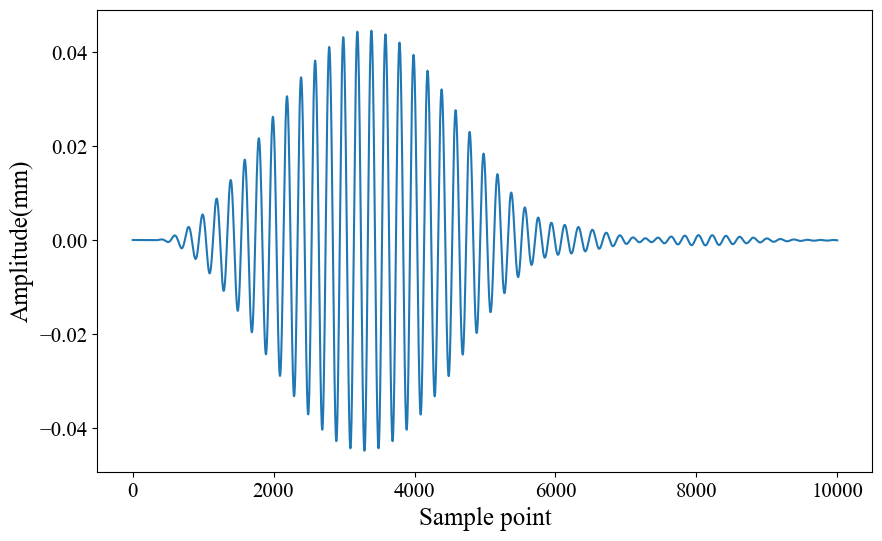

In [6]:
plt.style.use('default')
plt.figure(figsize=(10,6))
plt.rcParams['font.family'] = ['Times New Roman']
plt.plot(train_datas[0],linewidth=1.5)
plt.xlabel('Sample point',fontdict={'weight': 'normal', 'size': 18})
plt.ylabel('Amplitude(mm)',fontdict={'weight': 'normal', 'size': 18})
#坐标轴刻度大小设置
plt.tick_params(axis='both', which='major', labelsize=15)
plt.savefig('D:\\Desktop\\Python\\Signal_reconstruction\\Model\\ISCM\\MSE\\train_data.jpg', dpi=600, bbox_inches='tight')

In [7]:
def add_noise_with_snr(signal, snr_db):
    """
    根据信噪比（dB）为信号添加高斯噪声
    :param signal: 原始信号，形状为 [batch_size, 1, N]，类型为 torch.Tensor
    :param snr_db: 信噪比（dB）
    :return: 带噪声的信号，形状与输入信号相同
    """
    # 计算信号功率（逐样本计算）
    signal_power = torch.mean(signal ** 2, dim=(1, 2), keepdim=True)  # 形状为 [batch_size, 1, 1]
    
    # 将信噪比从分贝转换为线性比例
    snr_linear = 10 ** (snr_db / 10)
    
    # 计算噪声功率
    noise_power = signal_power / snr_linear
    
    # 生成高斯噪声（形状与信号相同）
    noise = torch.randn_like(signal) * torch.sqrt(noise_power)
    
    # 添加噪声
    noisy_signal = signal + noise
    
    return noisy_signal

In [8]:
BATCH_SIZE=10
EPOCH=200
learning_rate = 1e-4

In [9]:
# 准备数据
#torch.from_numpy将 NumPy 数组转换为 PyTorch 张量
#TensorDataset用于将张量数据和标签组合成一个数据集
#DataLoader用于从数据集中加载批次数据，并进行训练或测试

train_dataset = TensorDataset(torch.from_numpy(train_datas),torch.from_numpy(train_datas))
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

validation_dataset = TensorDataset(torch.from_numpy(validation_datas),torch.from_numpy(validation_datas))
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
def calculate_snr(x_prime,x):
    """
    计算信号的信噪比（SNR）。

    参数:
        x (numpy.ndarray): 干净信号。
        x_prime (numpy.ndarray): 噪声信号。

    返回:
        float: 信噪比，单位为 dB。
    """
    # 计算信号功率
    signal_power = torch.mean(x ** 2)
    noise = x_prime-x
    # 计算噪声功率
    noise_power = torch.mean(noise ** 2)
    
    # 计算信噪比
    if noise_power == 0:
        raise ValueError("噪声功率不能为零，这可能导致除以零的错误。")
    
    snr = 10 * torch.log10(signal_power / noise_power)
    
    snr_1 = snr.to(device)
    return snr_1.item()  # 将结果转换为 Python 标量

In [11]:
def calculate_pcc(x, y):
    """
    计算两个信号的皮尔逊相关系数（PCC）。

    参数:
        x (torch.Tensor): 第一个信号，假定在 CUDA 上。
        y (torch.Tensor): 第二个信号，假定在 CUDA 上。

    返回:
        float: 皮尔逊相关系数。
    """
    
    # 计算均值
    mean_x = torch.mean(x)
    mean_y = torch.mean(y)
    
    # 计算协方差
    covariance = torch.mean((x - mean_x) * (y - mean_y))
    
    # 计算标准差
    std_x = torch.std(x)
    std_y = torch.std(y)
    
    # 计算皮尔逊相关系数
    if std_x == 0 or std_y == 0:
        raise ValueError("标准差不能为零，这可能导致除以零的错误。")
    
    pcc = covariance / (std_x * std_y)

    pcc_1 = pcc.to(device)

    return pcc_1.item()  # 将结果转换为 Python 标量


In [12]:
class Conv1DEncoder(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, padding, compression_ratio):
        super(Conv1DEncoder, self).__init__()
        self.compression_ratio = compression_ratio
        
        if self.compression_ratio == 2:
            # 动态构建编码器
            encoder_layers = [
                nn.Conv1d(input_channels, input_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            ]
        
        if self.compression_ratio == 4:
            encoder_layers=[
                nn.Conv1d(input_channels, 4, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(4, output_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            ]
        
        if self.compression_ratio == 8:
            encoder_layers=[
                nn.Conv1d(input_channels, 4, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(4, 8, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(8, output_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            ]
        
        if self.compression_ratio == 16:
            encoder_layers=[
                nn.Conv1d(input_channels, 4, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(4, 8, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(8, 16, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(16, output_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            ]
        
        if self.compression_ratio == 32:
            encoder_layers=[
                nn.Conv1d(input_channels, 4, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(4, 8, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(8, 16, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding),
                nn.Tanh(),
                nn.Conv1d(32, output_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            ]
        
        # 将动态构建的层添加到 nn.Sequential 中
        self.encoder = nn.Sequential(*encoder_layers)
        
    def forward(self, x):
        return self.encoder(x)

class Conv1DDecoder(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, padding, compression_ratio):
        super(Conv1DDecoder, self).__init__()
        self.compression_ratio = compression_ratio

        if self.compression_ratio == 2:
            decoder_layers = [
                nn.ConvTranspose1d(input_channels, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding)
            ]

        if self.compression_ratio == 4:
            decoder_layers = [
                nn.ConvTranspose1d(input_channels,4, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(4, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding)
            ]

        if self.compression_ratio == 8:
            decoder_layers = [
                nn.ConvTranspose1d(input_channels,4, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(4, 8, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(8, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding)
            ]

        if self.compression_ratio == 16:
            decoder_layers = [
                nn.ConvTranspose1d(input_channels,4, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(4, 8, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(8, 16, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(16, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding)
            ]
        if self.compression_ratio == 32:
            decoder_layers = [
                nn.ConvTranspose1d(input_channels,4, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(4, 8, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(8, 16, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
                nn.Tanh(),
                nn.ConvTranspose1d(32, output_channels, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=padding),
            ]

        self.decoder = nn.Sequential(*decoder_layers)  
        
    def forward(self, x):
        return self.decoder(x)

class ISCM(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, stride, padding, compression_ratio):
        super(ISCM, self).__init__()
        self.encoder = Conv1DEncoder(input_channels, output_channels, kernel_size, stride, padding, compression_ratio)
        self.decoder = Conv1DDecoder(output_channels, input_channels, kernel_size, stride, padding, compression_ratio)
        
    def forward(self, x,SNR):
        encoded = self.encoder(x)
        x_noise=add_noise_with_snr(encoded,SNR)

        decoded = self.decoder(x_noise)
        x= decoded[:,:,:N]

        return x

In [13]:
A=1e4   #损失函数放大倍数

In [14]:
n=[2,4,8,16,32]
for k in n:
    print(f'Compression ratio:{k}')
    # 参数设置
    input_channels = 1
    output_channels = 1
    kernel_size = 4
    stride = 2
    padding = 1
    compression_ratio = k #（假设 k 是一个整数，表示最终压缩后的长度）
    SNR=20

    # 初始化模型
    model = ISCM(input_channels, output_channels, kernel_size, stride, padding, compression_ratio)
    model.to(device)
    loss = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #信噪比
    train_SNR=[]
    valid_SNR=[]

    #PCC
    train_PCC=[]
    valid_PCC=[]

    #两个空列表用于存储训练和验证中的损失值
    train_loss_epoch=[]

    #两个空列表用于存储训练和验证中的损失值
    valid_loss_epoch=[]
    

    #训练和验证阶段
    for epoch in range(EPOCH):
        if epoch % (EPOCH/10)==0:
            print("-------第 {} 轮训练开始-------".format(epoch+1)) 

        train_epoch = 0.0 #这段代码放在epoch循环中，每次循环时清零
        train_SNR_2 = 0.0
        train_PCC_2 = 0.0

        # 训练步骤开始
        model.train() #在训练模式下，模型会计算并反向传播误差，并更新模型参数   
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad() #在使用优化器更新参数之前，我们需要先将模型参数的梯度清零，
                                #以避免之前的梯度对当前梯度的影响
            
            x1=x.type(torch.FloatTensor)
            y1=y.type(torch.FloatTensor)

            x2,y2=x1.reshape(-1,1,train_datas.shape[1]),y1.reshape(-1,1,train_datas.shape[1])

            x3,y3 = x2.to(device),y2.to(device)

            y_hat = model(x3,SNR)

            SNR_1 = calculate_snr(y_hat,y3)
            train_SNR_2 += SNR_1*x2.size(0)

            PCC_1 = calculate_pcc(y_hat,y3)
            train_PCC_2 += PCC_1*x2.size(0)

            train_loss = A*loss(y_hat, y3)
            
            train_loss.backward()

            optimizer.step()

            train_epoch += train_loss.item() * x2.size(0)
            
        #计算一个 epoch 内的平均训练损失
        train_mean_length = train_epoch / len(train_loader.dataset)
        #将平均训练损失 train_mean_loss 添加到 train_loss_mean 列表中
        train_loss_epoch.append([train_mean_length])

        train_mean_SNR = train_SNR_2/len(train_loader.dataset)
        train_mean_PCC = train_PCC_2/len(train_loader.dataset)

        train_SNR.append(train_mean_SNR)
        train_PCC.append(train_mean_PCC)

        model.eval()
        valid_epoch = 0.0
        valid_SNR_2=0.0
        valid_PCC_2=0.0

        with torch.no_grad():
            for i, (x_data, y_label) in enumerate(validation_loader):
                
                x1=x_data.type(torch.FloatTensor)
                y1=y_label.type(torch.FloatTensor)

                x2,y2=x1.reshape(-1,1,train_datas.shape[1]),y1.reshape(-1,1,train_datas.shape[1])

                x3,y3 = x2.to(device),y2.to(device)
                
                y_hat = model(x3,SNR)

                SNR_1 = calculate_snr(y_hat,y3)
                valid_SNR_2 += SNR_1*x2.size(0)

                PCC_1 = calculate_pcc(y_hat,y3)
                valid_PCC_2 += PCC_1*x2.size(0)

                valid_loss = A* loss(y_hat, y3)

                valid_epoch += valid_loss.item() * x2.size(0)

            valid_mean_length = valid_epoch / len(validation_loader.dataset)
            valid_loss_epoch.append([valid_mean_length])

            valid_mean_SNR = valid_SNR_2/len(validation_loader.dataset)
            valid_mean_PCC = valid_PCC_2/len(validation_loader.dataset)

            valid_SNR.append(valid_mean_SNR)
            valid_PCC.append(valid_mean_PCC)

        if epoch % (EPOCH/10) == 0:
            print(f"Epoch:{epoch}, Train_Loss: {train_mean_length:.4f},Valid_Loss: {valid_mean_length:.4f}")

    #设置图形大小、像素
    fig=plt.figure(figsize=(10,6))
    plt.rcParams['figure.figsize']=(10,6)
    plt.rcParams['savefig.dpi'] = 600 #图片像素
    plt.rcParams['figure.dpi'] = 600
    #设置图形中坐标轴标签大小、刻度值字体及大小
    params = {'axes.labelsize': 18, 'axes.titlesize':18, 'legend.fontsize': 14, 'xtick.labelsize': 16, 'ytick.labelsize': 16,'font.family':'Times New roman'}
    plt.rcParams.update(params)

    host = host_subplot(111, axes_class=axisartist.Axes)
    plt.subplots_adjust(right=0.75)

    par1 = host.twinx()
    par2 = host.twinx()
    #设置第三根Y轴位置，这里选择是右边
    par2.axis["right"] = par2.new_fixed_axis(loc="right", offset=(60, 0))
    #设置Y轴刻度值、坐标轴标签显示
    par1.axis["right"].toggle(all=True)
    par2.axis["right"].toggle(all=True)

    #进行绘图
    p1, = host.plot(train_loss_epoch, 'ro-', linewidth=2.5, label='Training loss')
    p1, = host.plot(valid_loss_epoch, 'rs-', linewidth=2.5, label='Validation loss')

    p2, = par1.plot(train_SNR, 'go-', linewidth=2.5, label='Training SNR') 
    p2, = par1.plot(valid_SNR, 'gs-', linewidth=2.5, label='Validation SNR')  

    p3, = par2.plot(train_PCC, 'ko-', linewidth=2.5, label='Training PCC')  
    p3, = par2.plot(valid_PCC, 'ks-', linewidth=2.5, label='Validation PCC')  
    #设置x轴、y轴标签
    host.set_xlabel("Epoch")
    host.set_ylabel("Loss")
    par1.set_ylabel("SNR(dB)")
    par2.set_ylabel("PCC")
    #显示图例
    host.legend(frameon=False,fontsize='x-large')
    #设置y轴标签颜色
    host.axis["left"].label.set_color(p1.get_color())
    par1.axis["right"].label.set_color(p2.get_color())
    par2.axis["right"].label.set_color(p3.get_color())
    #将刻度线设置为向外
    host.axis[:].major_ticks.set_tick_out(True)
    par1.axis[:].major_ticks.set_tick_out(True)
    par2.axis[:].major_ticks.set_tick_out(True)

    # 保存图像
    plt.savefig(f'D:\\Desktop\\Python\\Signal_reconstruction\\Model\\ISCM\\MSE\\Model_Loss_MSE_{k}.jpg', dpi=600, bbox_inches='tight')
    #显示图形
    plt.show()

torch.save(model, f'D:\\Desktop\\Python\\Signal_reconstruction\\Model\\ISCM\\MSE\\model_signal_reconstruction_MSE.pth') 
print(f"The model of the compression ratio has been saved")
    

Compression ratio:2
-------第 1 轮训练开始-------
Epoch:0, Train_Loss: 520.8231,Valid_Loss: 448.6522
-------第 21 轮训练开始-------
Epoch:20, Train_Loss: 2.6670,Valid_Loss: 2.6602
-------第 41 轮训练开始-------
Epoch:40, Train_Loss: 2.0148,Valid_Loss: 1.9891
-------第 61 轮训练开始-------
Epoch:60, Train_Loss: 0.5989,Valid_Loss: 0.5673
-------第 81 轮训练开始-------
Epoch:80, Train_Loss: 0.0261,Valid_Loss: 0.0246
-------第 101 轮训练开始-------
Epoch:100, Train_Loss: 0.0089,Valid_Loss: 0.0096
-------第 121 轮训练开始-------
Epoch:120, Train_Loss: 0.0081,Valid_Loss: 0.0088
-------第 141 轮训练开始-------
Epoch:140, Train_Loss: 0.0081,Valid_Loss: 0.0087
-------第 161 轮训练开始-------
Epoch:160, Train_Loss: 0.0081,Valid_Loss: 0.0088
-------第 181 轮训练开始-------
Epoch:180, Train_Loss: 0.0081,Valid_Loss: 0.0088
Compression ratio:4
-------第 1 轮训练开始-------
Epoch:0, Train_Loss: 372.9335,Valid_Loss: 285.1618
-------第 21 轮训练开始-------
Epoch:20, Train_Loss: 0.7473,Valid_Loss: 0.7692
-------第 41 轮训练开始-------
Epoch:40, Train_Loss: 0.0189,Valid_Loss: 0.02